In [1]:
%load_ext autoreload
%autoreload 2

In [72]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

In [3]:
import sys
sys.path.append('/Users/Tim/PycharmProjects/HOI/')

In [4]:
from HOI.preprocessings import compute_kernel, compute_kernel_n
from HOI.tests import test_independence
from synthetic_data import stationary_pb_ts, nonstationary_ts_n, stationary_pb_ts_n

In [85]:
def find_comb(var):
    power_set = []
    for L in range(len(var) + 1):
        for subset in itertools.combinations(var, L):
            if len(subset) >= 2:
                power_set.append(list(subset))
    return power_set

# Data Preprocessing

In [256]:
df = pd.read_csv('/Users/tim/PycharmProjects/HOI/examples/PRSA_data_2010.1.1-2014.12.31.csv')

In [257]:
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [258]:
df[(df['month']==7) & (df['year']==2010)].isna().sum()

No       0
year     0
month    0
day      0
hour     0
pm2.5    0
DEWP     0
TEMP     0
PRES     0
cbwd     0
Iws      0
Is       0
Ir       0
dtype: int64

In [259]:
df[(df['month']==7) & (df['year']==2010)].shape

(744, 13)

In [260]:
df_var_wk = df[(df['month']==7) & (df['year']==2010)]

In [261]:
df_var_wk = df_var_wk.drop(['No', 'year', 'month', 'day', 'hour','cbwd', 'Iws', 'Is', 'Ir'], axis=1)

In [262]:
# differencing xt+1 - xt

In [263]:
df_var_wk['pm2.5'] = df_var_wk['pm2.5'].diff()
df_var_wk['DEWP'] = df_var_wk['DEWP'].diff()
df_var_wk['TEMP'] = df_var_wk['TEMP'].diff()
df_var_wk['PRES'] = df_var_wk['PRES'].diff()

In [264]:
# then differencing xt+12 - xt

In [265]:
df_var_wk['d52_pm2.5'] = df_var_wk['pm2.5'].diff(periods=12)
df_var_wk['d52_DEWP'] = df_var_wk['DEWP'].diff(periods=12)
df_var_wk['d52_TEMP'] = df_var_wk['TEMP'].diff(periods=12)
df_var_wk['d52_PRES'] = df_var_wk['PRES'].diff(periods=12)

In [266]:
# var_df_2010_diff = var_df_2010[['pm2.5', 'DEWP', 'TEMP', 'PRES']]
df_var_wk_d12 = df_var_wk[['d52_pm2.5', 'd52_DEWP', 'd52_TEMP', 'd52_PRES']]

In [270]:
df_var_wk_d12

,diff_d12_pm2.5,diff_d12_DEWP,diff_d12_TEMP,diff_d12_PRES
4344,NaN,NaN,NaN,NaN
4345,NaN,NaN,NaN,NaN
4346,NaN,NaN,NaN,NaN
4347,NaN,NaN,NaN,NaN
4348,NaN,NaN,NaN,NaN
...,...,...,...,...
5083,20.0,-1.0,-1.0,2.0
5084,-14.0,0.0,-2.0,1.0
5085,-33.0,1.0,-1.0,0.0
5086,-8.0,6.0,0.0,0.0


In [184]:
# normalisation by -mean & /std

In [275]:
std_df = df_var_wk_d12[13:].apply(lambda iterator: (iterator - iterator.mean())/iterator.std())

In [276]:
std_df

,diff_d12_pm2.5,diff_d12_DEWP,diff_d12_TEMP,diff_d12_PRES
4357,0.449659,0.002872,0.000712,1.246418
4358,-0.252829,-0.696849,0.000712,-0.012051
4359,-2.136774,0.002872,0.521166,1.246418
4360,-1.657805,-0.696849,-0.519742,-0.012051
4361,0.130346,-1.396569,0.000712,-0.012051
...,...,...,...,...
5083,0.641246,-0.696849,-0.519742,2.504887
5084,-0.444417,0.002872,-1.040196,1.246418
5085,-1.051111,0.702592,-0.519742,-0.012051
5086,-0.252829,4.201193,0.000712,-0.012051


In [277]:
data_dict, kernel_dict = compute_kernel(std_df)

In [279]:
power_set_k = find_comb([kernel_dict['d52_pm2.5'], kernel_dict['d52_DEWP'], kernel_dict['d52_TEMP'], kernel_dict['d52_PRES']])

In [280]:
power_set_d = find_comb([data_dict['d52_pm2.5'], data_dict['d52_DEWP'], data_dict['d52_TEMP'], data_dict['d52_PRES']])

In [281]:
power_set_name = find_comb(['pm2.5', 'DEWP', 'TEMP', 'PRES'])

In [284]:
power = {}
for (name, klist, dlist) in tqdm(zip(power_set_name, power_set_k, power_set_d), total=len(power_set)):
    rejects = 0
    for i in tqdm(range(10)):
        _, _, _, reject = test_independence(klist, dlist, n_perms=500, alpha=0.05, mode = 'shifting')
        rejects = rejects + reject
    power[str(name)] = rejects
    print(power)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 0}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 0, "['pm2.5', 'TEMP']": 0}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 0, "['pm2.5', 'TEMP']": 0, "['pm2.5', 'PRES']": 0}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 0, "['pm2.5', 'TEMP']": 0, "['pm2.5', 'PRES']": 0, "['DEWP', 'TEMP']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 0, "['pm2.5', 'TEMP']": 0, "['pm2.5', 'PRES']": 0, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 0}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 0, "['pm2.5', 'TEMP']": 0, "['pm2.5', 'PRES']": 0, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 0, "['TEMP', 'PRES']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 0, "['pm2.5', 'TEMP']": 0, "['pm2.5', 'PRES']": 0, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 0, "['TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 0, "['pm2.5', 'TEMP']": 0, "['pm2.5', 'PRES']": 0, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 0, "['TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP']": 10, "['pm2.5', 'DEWP', 'PRES']": 0}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 0, "['pm2.5', 'TEMP']": 0, "['pm2.5', 'PRES']": 0, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 0, "['TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP']": 10, "['pm2.5', 'DEWP', 'PRES']": 0, "['pm2.5', 'TEMP', 'PRES']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 0, "['pm2.5', 'TEMP']": 0, "['pm2.5', 'PRES']": 0, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 0, "['TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP']": 10, "['pm2.5', 'DEWP', 'PRES']": 0, "['pm2.5', 'TEMP', 'PRES']": 10, "['DEWP', 'TEMP', 'PRES']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 0, "['pm2.5', 'TEMP']": 0, "['pm2.5', 'PRES']": 0, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 0, "['TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP']": 10, "['pm2.5', 'DEWP', 'PRES']": 0, "['pm2.5', 'TEMP', 'PRES']": 10, "['DEWP', 'TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP', 'PRES']": 10}


In [288]:
from statsmodels.tsa.stattools import adfuller
 
# extracting only the passengers count using values function
values = std_df['d52_TEMP']
 
# passing the extracted passengers count to adfuller function.
# result of adfuller function is stored in a res variable
res = adfuller(values)
 
# Printing the statistical result of the adfuller test
print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])

Augmneted Dickey_fuller Statistic: -9.880149
p-value: 0.000000


# weekly data over 5 years

In [53]:
df = pd.read_csv('/Users/tim/PycharmProjects/HOI/examples/PRSA_data_2010.1.1-2014.12.31.csv')

In [54]:
df.shape

(43800, 13)

In [55]:
df_var = df.drop(['No', 'year', 'month', 'day', 'hour','cbwd', 'Iws', 'Is', 'Ir'], axis=1)

In [56]:
df_var

,pm2.5,DEWP,TEMP,PRES
0,NaN,-21,-11.0,1021.0
1,NaN,-21,-12.0,1020.0
2,NaN,-21,-11.0,1019.0
3,NaN,-21,-14.0,1019.0
4,NaN,-20,-12.0,1018.0
...,...,...,...,...
43795,8.0,-23,-2.0,1034.0
43796,10.0,-22,-3.0,1034.0
43797,10.0,-22,-3.0,1034.0
43798,8.0,-22,-4.0,1034.0


In [58]:
df_var_wk = df_var.groupby(df_var.index // (7*24)).mean()

In [60]:
df_var_wk

,pm2.5,DEWP,TEMP,PRES
0,70.666667,-18.255952,-10.202381,1027.910714
1,70.946429,-19.035714,-10.029762,1030.035714
2,163.660714,-12.630952,-4.946429,1030.386905
3,68.227723,-17.404762,-2.672619,1026.196429
4,53.410714,-17.565476,-2.083333,1025.273810
...,...,...,...,...
256,76.614458,-17.095238,-1.517857,1026.392857
257,84.708609,-14.166667,-1.023810,1029.714286
258,84.547619,-15.291667,-2.172619,1027.934524
259,65.421384,-14.398810,-0.863095,1028.321429


In [63]:
df_var_wk['d52_pm2.5'] = df_var_wk['pm2.5'].diff(periods=52)
df_var_wk['d52_DEWP'] = df_var_wk['DEWP'].diff(periods=52)
df_var_wk['d52_TEMP'] = df_var_wk['TEMP'].diff(periods=52)
df_var_wk['d52_PRES'] = df_var_wk['PRES'].diff(periods=52)

In [70]:
df_var_wk['d1_d52_pm2.5'] = df_var_wk['d52_pm2.5'].diff(periods=1)
df_var_wk['d1_d52_DEWP'] = df_var_wk['d52_DEWP'].diff(periods=1)
df_var_wk['d1_d52_TEMP'] = df_var_wk['d52_TEMP'].diff(periods=1)
df_var_wk['d1_d52_PRES'] = df_var_wk['d52_PRES'].diff(periods=1)

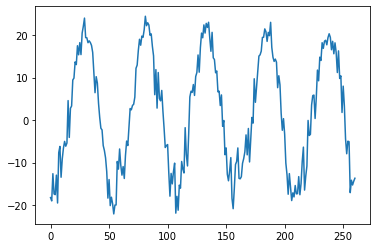

In [62]:
plt.plot(df_var_wk['DEWP'])

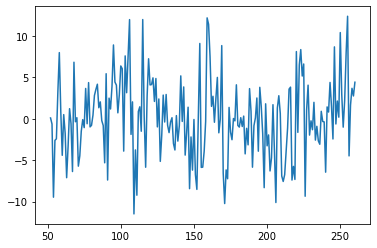

In [64]:
plt.plot(df_var_wk['d52_DEWP'])

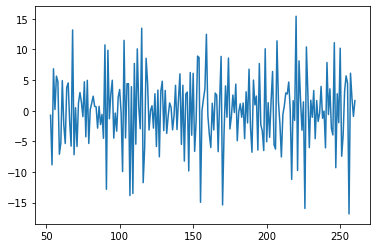

In [71]:
plt.plot(df_var_wk['d1_d52_DEWP'])

In [75]:
df_var_wk_nan = df_var_wk[['d1_d52_pm2.5', 'd1_d52_DEWP', 'd1_d52_TEMP', 'd1_d52_PRES']]

In [79]:
df_var_wk_nan = df_var_wk_nan.dropna()

In [84]:
df_var_wk_nan

,d1_d52_pm2.5,d1_d52_DEWP,d1_d52_TEMP,d1_d52_PRES
53,10.748016,-0.732143,0.672619,-6.994048
54,-134.488095,-8.827381,-7.321429,6.583333
55,114.444896,6.851190,-1.226190,3.428571
56,7.501532,0.196429,3.428571,-4.208333
57,29.880952,5.648810,1.726190,-10.202381
...,...,...,...,...
256,-82.971834,-16.851190,-6.297619,2.815476
257,-3.399896,6.130952,3.940476,3.125000
258,31.505174,2.023810,2.291667,-12.285714
259,-80.679305,-0.922619,1.130952,0.059524


In [86]:
std_df = df_var_wk_nan.apply(lambda iterator: (iterator - iterator.mean())/iterator.std())

In [87]:
std_df

,d1_d52_pm2.5,d1_d52_DEWP,d1_d52_TEMP,d1_d52_PRES
53,0.126368,-0.128097,0.235090,-1.367928
54,-1.642441,-1.505449,-2.424497,1.288221
55,1.389277,1.162159,-0.396636,0.671053
56,0.086830,0.029894,1.151985,-0.822958
57,0.359385,0.957581,0.585609,-1.995576
...,...,...,...,...
256,-1.015032,-2.870648,-2.083880,0.551113
257,-0.045937,1.039615,1.322293,0.611665
258,0.379167,0.340811,0.773741,-2.403140
259,-0.987112,-0.160505,0.387576,0.011965


In [88]:
data_dict, kernel_dict = compute_kernel(std_df)

In [89]:
power_set_k = find_comb([kernel_dict['d1_d52_pm2.5'], kernel_dict['d1_d52_DEWP'], kernel_dict['d1_d52_TEMP'], kernel_dict['d1_d52_PRES']])

In [90]:
power_set_d = find_comb([data_dict['d1_d52_pm2.5'], data_dict['d1_d52_DEWP'], data_dict['d1_d52_TEMP'], data_dict['d1_d52_PRES']])

In [91]:
power_set_name = find_comb(['pm2.5', 'DEWP', 'TEMP', 'PRES'])

In [94]:
power = {}
for (name, klist, dlist) in tqdm(zip(power_set_name, power_set_k, power_set_d), total=len(power_set_k)):
    rejects = 0
    for i in tqdm(range(10)):
        _, _, _, reject = test_independence(klist, dlist, n_perms=1000, alpha=0.05, mode = 'shifting')
        rejects = rejects + reject
    power[str(name)] = rejects
    print(power)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 10, "['pm2.5', 'TEMP']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 10, "['pm2.5', 'TEMP']": 10, "['pm2.5', 'PRES']": 1}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 10, "['pm2.5', 'TEMP']": 10, "['pm2.5', 'PRES']": 1, "['DEWP', 'TEMP']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 10, "['pm2.5', 'TEMP']": 10, "['pm2.5', 'PRES']": 1, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 10, "['pm2.5', 'TEMP']": 10, "['pm2.5', 'PRES']": 1, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 10, "['TEMP', 'PRES']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 10, "['pm2.5', 'TEMP']": 10, "['pm2.5', 'PRES']": 1, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 10, "['TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 10, "['pm2.5', 'TEMP']": 10, "['pm2.5', 'PRES']": 1, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 10, "['TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP']": 10, "['pm2.5', 'DEWP', 'PRES']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 10, "['pm2.5', 'TEMP']": 10, "['pm2.5', 'PRES']": 1, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 10, "['TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP']": 10, "['pm2.5', 'DEWP', 'PRES']": 10, "['pm2.5', 'TEMP', 'PRES']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 10, "['pm2.5', 'TEMP']": 10, "['pm2.5', 'PRES']": 1, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 10, "['TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP']": 10, "['pm2.5', 'DEWP', 'PRES']": 10, "['pm2.5', 'TEMP', 'PRES']": 10, "['DEWP', 'TEMP', 'PRES']": 10}


  0%|          | 0/10 [00:00<?, ?it/s]

{"['pm2.5', 'DEWP']": 10, "['pm2.5', 'TEMP']": 10, "['pm2.5', 'PRES']": 1, "['DEWP', 'TEMP']": 10, "['DEWP', 'PRES']": 10, "['TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP']": 10, "['pm2.5', 'DEWP', 'PRES']": 10, "['pm2.5', 'TEMP', 'PRES']": 10, "['DEWP', 'TEMP', 'PRES']": 10, "['pm2.5', 'DEWP', 'TEMP', 'PRES']": 10}
